In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Enable quiet mode to hide verbose output
!pip install -q nilearn

# Ensure a stable PyTorch version
!pip install -q torch==2.5.1 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# Install compatible PyG wheels for torch 2.5.1 + cu121
!pip install -q torch-scatter==2.1.2 -f https://data.pyg.org/whl/torch-2.5.1+cu121.html
!pip install -q torch-geometric==2.6.1

# Check installations
import torch, nilearn
import torch_geometric
print("Torch:", torch.__version__)
print("Nilearn:", nilearn.__version__)
print("PyG:", torch_geometric.__version__)

Torch: 2.5.1+cu121
Nilearn: 0.12.1
PyG: 2.6.1


In [3]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import global_add_pool, GATConv
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.utils import softmax
from nilearn.plotting import plot_connectome, plot_matrix, show
import math
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap

In [ ]:
corr_dir = '/content/drive/Shareddrives/291A_Brain_Connectomes/FullCorrelationSubjects'
# corr_dir = '/content/drive/MyDrive/temp/FullCorrTrain'

subject_ids = [
  os.path.splitext(f)[0]
  for f in os.listdir(corr_dir)
  if f.endswith(".csv")
]

phen_df = pd.read_csv('/content/drive/Shareddrives/291A_Brain_Connectomes/AABC_Release1_Non-imaging_Data-XL.csv', usecols=[0, 7, 381, 475, 2343], header=1) # 0 - subject_id, 7 - age, 381 - moca_sum, 476 - ravlt_learning_score
phen_df.head()

id_event age_open  moca_sum  ravlt_learning_score  psqi_global
0  HCA6000030_V1       86      22.0                   1.0          5.0
1  HCA6002236_V1       46      25.0                   7.0          6.0
2  HCA6002236_F1       47       NaN                   NaN          NaN
3  HCA6002236_V2       48      27.0                   9.0          2.0
4  HCA6002236_F2       49       NaN                   NaN          NaN

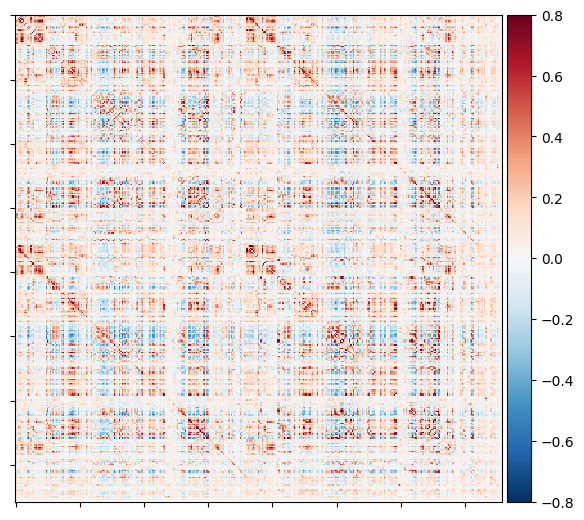

In [6]:
test_subject = subject_ids[0]
fullcorr = pd.read_csv(os.path.join(corr_dir, f"{test_subject}.csv"))
fullcorr = np.array(fullcorr.drop(fullcorr.columns[0], axis=1).select_dtypes(include="number"))
plot_matrix(fullcorr, vmin=-0.8, vmax=0.8)
show()

In [ ]:
phen = phen_df.set_index('id_event')

dataset = []
count = 0

for si in subject_ids:
  row_vals = phen.loc[si]
  if row_vals.notna().all():
    filename = f"{si}.csv"
    A = pd.read_csv(os.path.join(corr_dir, filename))
    A_t = torch.from_numpy(np.array(A.drop(A.columns[0], axis=1).select_dtypes(include="number")))


    edge_index=torch.nonzero(A_t != 0, as_tuple=False).t().contiguous()
    edge_attr = A_t[edge_index[0], edge_index[1]].clone()

    data = Data(
        x=A_t,
        edge_index=edge_index,
        edge_attr=edge_attr,
        age=torch.tensor(int(row_vals['age_open'].split()[0])),
        moca=torch.tensor(row_vals['moca_sum']),
        ravlt=torch.tensor(row_vals['ravlt_learning_score']),
        psqi=torch.tensor(row_vals['psqi_global']),
        subject_id=si
    )
    dataset.append(data)

print(len(dataset))

496


In [8]:
cond_vars = ['age', 'moca', 'ravlt', 'psqi']
vals = np.array([[float(getattr(d, c)) for c in cond_vars] for d in dataset])
scaler = StandardScaler().fit(vals)

for d in dataset:
  d_vals = scaler.transform([ [float(getattr(d, c)) for c in cond_vars] ])[0]
  for i, c in enumerate(cond_vars):
      setattr(d, c, torch.tensor(d_vals[i], dtype=torch.float32))

In [9]:
# scaler.inverse_transform()

In [12]:
train_data = dataset

In [13]:
# condVAE with cond latent

In [ ]:
class ConditionalGATVAE(nn.Module):
  def __init__(self, input_dim=379, hidden_dim=128, latent_dim=16, free_dim=12, num_heads=4):
    super(ConditionalGATVAE, self).__init__()
    self.input_dim = input_dim

    self.gat1 = GATConv(input_dim, hidden_dim, heads=num_heads, concat=True, dropout=0.3, add_self_loops=False)
    self.gat2 = GATConv(hidden_dim*num_heads, hidden_dim, heads=1, concat=True, dropout=0.2, add_self_loops=False)
    self.pool_att = nn.Linear(hidden_dim, 1)

    self.fc_mu = nn.Linear(hidden_dim, free_dim)
    self.fc_logvar = nn.Linear(hidden_dim, free_dim)

    # MLP
    # self.fc3 = nn.Linear(latent_dim, hidden_dim)
    # self.fc4 = nn.Linear(hidden_dim, input_dim*input_dim)

    # Inner Product
    # self.node_emb_dim = 64
    # self.fc3 = nn.Linear(latent_dim, hidden_dim)
    # self.fc4 = nn.Linear(hidden_dim, input_dim * self.node_emb_dim)

    # Hybrid
    self.node_emb_dim = 64
    self.fc_embed = nn.Linear(latent_dim, input_dim * self.node_emb_dim)
    self.res_mlp = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim * input_dim)
    )

  def encode(self, x, edge_index, batch):
    h = F.elu(self.gat1(x, edge_index))
    h = F.elu(self.gat2(h, edge_index))

    scores = self.pool_att(h).squeeze(-1)
    alpha = softmax(scores, batch)
    h_graph = global_add_pool(h * alpha.unsqueeze(-1), batch)

    mu = self.fc_mu(h_graph)
    logvar = self.fc_logvar(h_graph)

    return mu, logvar, alpha

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

  # def decode(self, z):
  #   h = F.relu(self.fc3(z))
  #   # return torch.tanh(self.fc4(h)).view(-1, self.input_dim, self.input_dim)
  #   return self.fc4(h).view(-1, self.input_dim, self.input_dim)

  # def decode(self, z):
  #   # Expand graph-level latent to node-level embeddings
  #   # z: [batch, latent_dim]
  #   # Return: node embeddings [batch, 379, k]
  #   node_emb_dim = 64
  #   h = F.relu(self.fc3(z))           # [batch, hidden_dim]
  #   node_emb = self.fc4(h)            # [batch, 379 * node_emb_dim]
  #   node_emb = node_emb.view(-1, self.input_dim, node_emb_dim)

  #   # Inner product decoder
  #   A_hat = torch.matmul(node_emb, node_emb.transpose(1, 2))
  #   return A_hat

  def decode(self, z):
    B = z.size(0)

    # Inner-product component
    node_emb = self.fc_embed(z)                        # [B, 379*64]
    node_emb = node_emb.view(B, self.input_dim, self.node_emb_dim)
    A_ip = torch.matmul(node_emb, node_emb.transpose(1, 2))  # [B, 379, 379]

    # Residual MLP component
    A_res = self.res_mlp(z).view(B, self.input_dim, self.input_dim)

    # Combine
    A_hat = A_ip + 0.2*A_res

    return A_hat

  def forward(self, data):
    mu, logvar, alpha = self.encode(data.x, data.edge_index, data.batch)
    z_free = self.reparameterize(mu, logvar)
    # cond = torch.cat([data.age.unsqueeze(1), data.moca.unsqueeze(1), data.ravlt.unsqueeze(1), data.psqi.unsqueeze(1)], dim=1)
    # z = torch.cat([cond, z_free], dim=1)
    z = torch.cat([torch.stack([data.age, data.moca, data.ravlt, data.psqi], dim=1), z_free], dim=1)
    return self.decode(z), mu, logvar, alpha

def loss_function(recon_x, x, mu, logvar, beta):
  recon_loss = F.mse_loss(recon_x, x, reduction='mean')
  # recon_loss = F.l1_loss(recon_x, x, reduction='mean')
  # recon_loss = torch.norm(recon_x - x, p='fro') / x.size(1)
  kl_loss = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
  # kl_per_dim = 0.5 * (-1 - logvar + mu.pow(2) + logvar.exp())
  # kl_loss = torch.sum(torch.maximum(kl_per_dim - 1, torch.zeros_like(kl_per_dim)), dim=1).mean()
  return recon_loss + (beta*kl_loss), recon_loss, kl_loss

def train_model(model, dataloader, optimizer, num_epochs=50, device='cpu'):
  model.to(device)
  for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_recon = 0
    total_kl = 0

    for batch in dataloader:
      batch_data = batch.to(device)
      batch_data.x = batch_data.x.float()
      optimizer.zero_grad()
      recon_x, mu, logvar, alpha = model(batch_data)
      beta = min(1.0, epoch / 50)
      # beta = (1 - math.cos(math.pi * epoch / 40)) / 2
      loss, recon, kl = loss_function(recon_x.view(-1, recon_x.size(-1)), batch_data.x, mu, logvar, beta)
      total_loss += loss.item()
      total_recon += recon.item()
      total_kl += kl.item()
      loss.backward()
      optimizer.step()

    avg_total = total_loss / len(dataloader)
    avg_recon = total_recon / len(dataloader)
    avg_kl = total_kl / len(dataloader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_total:.4f}, Recon Loss: {avg_recon:.4f}, KL Loss: {avg_kl:.4f}")

  return model

model = ConditionalGATVAE()
train_loader = DataLoader(train_data, batch_size=4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = train_model(model, train_loader, optimizer, num_epochs=50, device=device)

Epoch [1/50], Loss: 1.3721, Recon Loss: 1.3721, KL Loss: 30.0200
Epoch [2/50], Loss: 0.6497, Recon Loss: 0.3283, KL Loss: 16.0697
Epoch [3/50], Loss: 0.5931, Recon Loss: 0.2769, KL Loss: 7.9053
Epoch [4/50], Loss: 0.5748, Recon Loss: 0.2572, KL Loss: 5.2940
Epoch [5/50], Loss: 0.5032, Recon Loss: 0.2337, KL Loss: 3.3689
Epoch [6/50], Loss: 0.3703, Recon Loss: 0.2116, KL Loss: 1.5875
Epoch [7/50], Loss: 0.2209, Recon Loss: 0.1533, KL Loss: 0.5629
Epoch [8/50], Loss: 0.1128, Recon Loss: 0.0945, KL Loss: 0.1310
Epoch [9/50], Loss: 0.0592, Recon Loss: 0.0547, KL Loss: 0.0282
Epoch [10/50], Loss: 0.0386, Recon Loss: 0.0368, KL Loss: 0.0097
Epoch [11/50], Loss: 0.0277, Recon Loss: 0.0268, KL Loss: 0.0047
Epoch [12/50], Loss: 0.0225, Recon Loss: 0.0220, KL Loss: 0.0026
Epoch [13/50], Loss: 0.0198, Recon Loss: 0.0194, KL Loss: 0.0018
Epoch [14/50], Loss: 0.0178, Recon Loss: 0.0175, KL Loss: 0.0014
Epoch [15/50], Loss: 0.0165, Recon Loss: 0.0162, KL Loss: 0.0011
Epoch [16/50], Loss: 0.0157, Rec

In [16]:
model.eval()

ConditionalGATVAE(
  (gat1): GATConv(379, 128, heads=4)
  (gat2): GATConv(512, 128, heads=1)
  (pool_att): Linear(in_features=128, out_features=1, bias=True)
  (fc_mu): Linear(in_features=128, out_features=12, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=12, bias=True)
  (fc_embed): Linear(in_features=16, out_features=24256, bias=True)
  (res_mlp): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=143641, bias=True)
  )
)

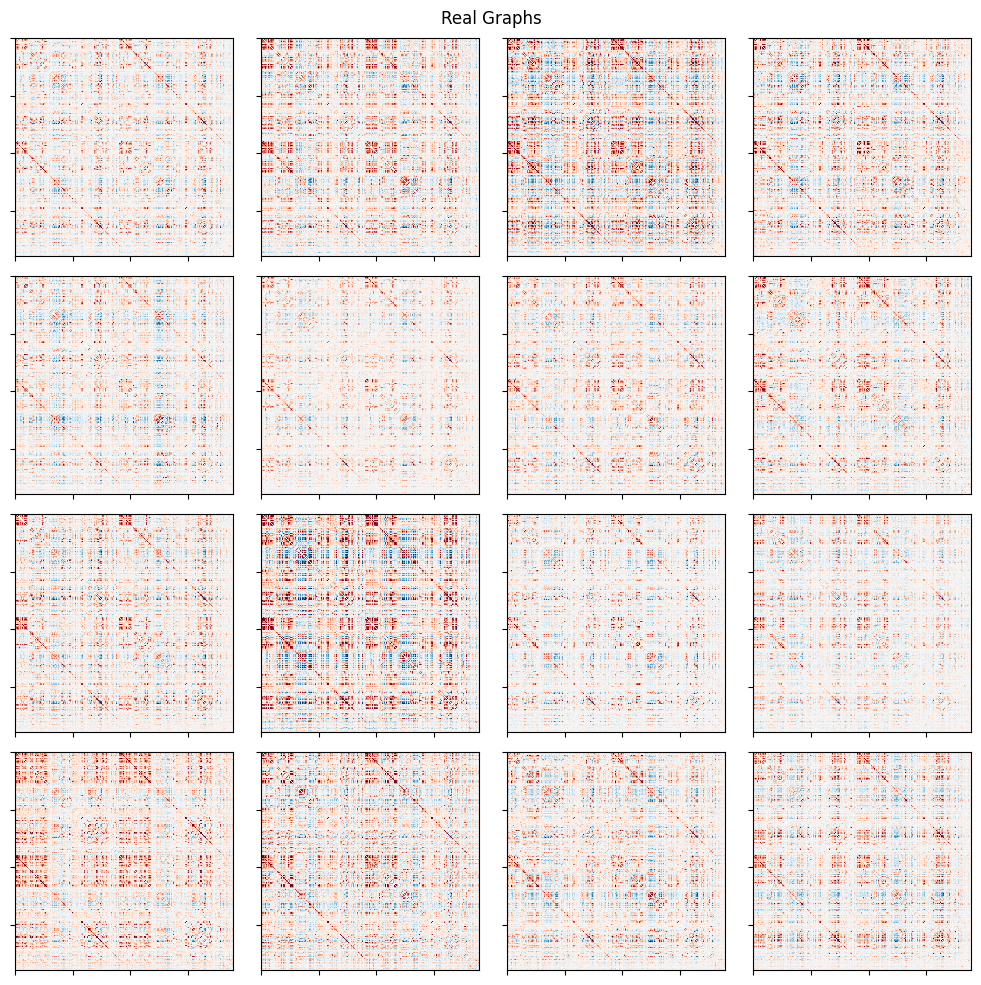

In [17]:
n_rows = 4
n_cols = 4
files = os.listdir(corr_dir)
random_subjects = np.random.choice(files, n_rows*n_cols*2, replace=False)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))
axes = axes.flatten()
count = 0
z_conds = []
subjects = []
while count < (n_rows*n_cols):
  s = os.path.splitext(random_subjects[count-1])[0]
  row_vals = phen.loc[s]
  if row_vals.isna().any():
    continue
  else:
    subjects.append(s)
    count += 1
  vals = np.array([int(row_vals['age_open'].split()[0]), row_vals['moca_sum'], row_vals['ravlt_learning_score'], row_vals['psqi_global']], dtype=np.float32)
  z_conds.append(torch.tensor(scaler.transform(vals.reshape(1, -1)),  dtype=torch.float32))
  ax = axes[count-1]
  subject = pd.read_csv(os.path.join(corr_dir, random_subjects[count-1]))
  subject_mat =  np.array(subject.drop(subject.columns[0], axis=1).select_dtypes(include="number"))
  plot_matrix(subject_mat, colorbar=False, vmin=-0.8, vmax=0.8, axes=ax)
plt.suptitle("Real Graphs")
plt.tight_layout()
plt.show()

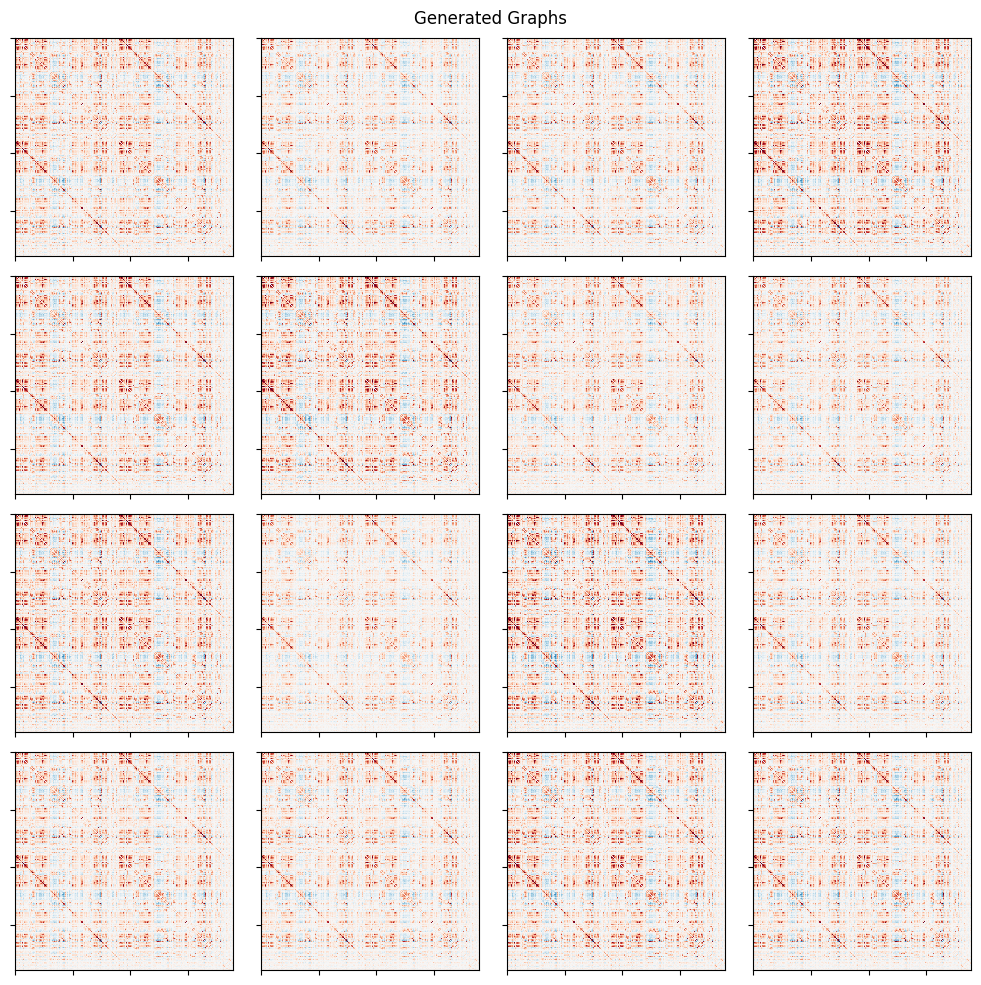

In [19]:
def generate_graph(model, z_cond, device='cpu'):
  z_cond = z_cond.to(device)
  z_free = torch.randn(1, 12, device=device)
  z = torch.cat((z_cond, z_free), dim=1)
  with torch.no_grad():
    new_node_features = model.decode(z)

  new_node_features = new_node_features.detach().view(379, -1)
  return new_node_features.cpu().numpy()

def generate_multiple_graphs(model, z_conds, device='cpu'):
  generated_graphs = []
  for i in range(len(z_conds)):
    adj_matrix = generate_graph(model, z_conds[i], device)
    generated_graphs.append(adj_matrix)
  return generated_graphs

def plot_multiple_graphs(graphs):
  for i, adj_matrix in enumerate(graphs):
    plot_matrix(adj_matrix, colorbar=False, vmin=-0.8, vmax=0.8)
    plt.show()

n_rows=4
n_cols=4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))
axes = axes.flatten()
graphs = generate_multiple_graphs(model, z_conds, device=device)
for i in range(n_rows*n_cols):
  ax = axes[i]
  plot_matrix(graphs[i], colorbar=False, vmin=-0.8, vmax=0.8, axes=ax)
plt.suptitle("Generated Graphs")
plt.tight_layout()
plt.show()

In [20]:
all_latent = []
all_age = []
all_moca = []
all_ravlt = []
all_psqi = []

with torch.no_grad():
  for batch in train_loader:
    batch = batch.to(device='cuda' if torch.cuda.is_available() else 'cpu')
    batch.x = batch.x.float()
    mu, _, _ = model.encode(batch.x, batch.edge_index, batch.batch)
    cond = torch.cat([batch.age.unsqueeze(1), batch.moca.unsqueeze(1), batch.ravlt.unsqueeze(1), batch.psqi.unsqueeze(1)], dim=1)
    latent_with_cond = torch.cat([cond, mu], dim=1)
    all_latent.append(latent_with_cond.detach().cpu())

    all_age.append(batch.age.detach().cpu())
    all_moca.append(batch.moca.detach().cpu())
    all_ravlt.append(batch.ravlt.detach().cpu())
    all_psqi.append(batch.psqi.detach().cpu())

all_latent = torch.cat(all_latent, dim=0).numpy()
all_age = torch.cat(all_age, dim=0).numpy()
all_moca = torch.cat(all_moca, dim=0).numpy()
all_ravlt = torch.cat(all_ravlt, dim=0).numpy()
all_psqi = torch.cat(all_psqi, dim=0).numpy()

all_labels = [all_age, all_moca, all_ravlt, all_psqi]

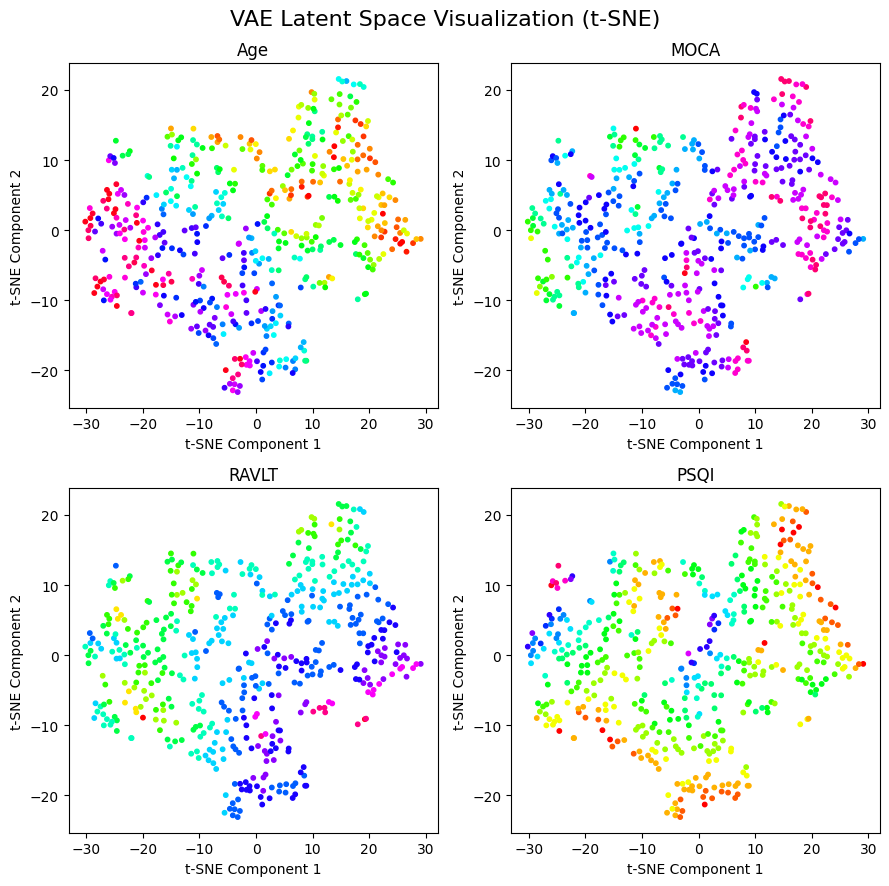

In [22]:
n_rows = 2
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(9, 9))
axes = axes.flatten()
titles = ["Age", "MOCA", "RAVLT", "PSQI"]
latent_2d_tsne = TSNE(n_components=2, random_state=42).fit_transform(all_latent)
for i in range(n_rows * n_cols):
  ax = axes[i]
  ax.scatter(latent_2d_tsne[:, 0], latent_2d_tsne[:, 1], c=all_labels[i], cmap='hsv', s=10)
  ax.set_title(titles[i])
  ax.set_xlabel("t-SNE Component 1")
  ax.set_ylabel("t-SNE Component 2")

plt.suptitle("VAE Latent Space Visualization (t-SNE)", fontsize=16)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


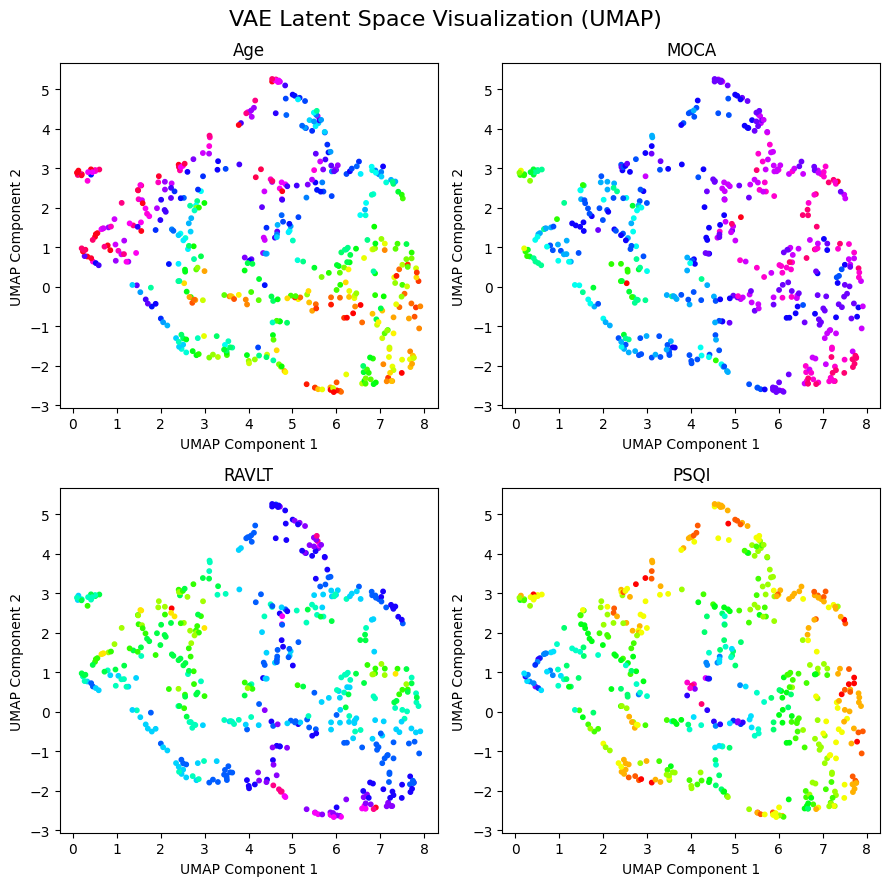

In [23]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(9, 9))
axes = axes.flatten()
reducer = umap.UMAP(n_components=2, random_state=42)
latent_2d_umap = reducer.fit_transform(all_latent)
for i in range(n_rows * n_cols):
  ax = axes[i]
  ax.scatter(latent_2d_umap[:, 0], latent_2d_umap[:, 1], c=all_labels[i], cmap='hsv', s=10)
  ax.set_title(titles[i])
  ax.set_xlabel("UMAP Component 1")
  ax.set_ylabel("UMAP Component 2")

plt.suptitle("VAE Latent Space Visualization (UMAP)", fontsize=16)
plt.tight_layout()
plt.show()

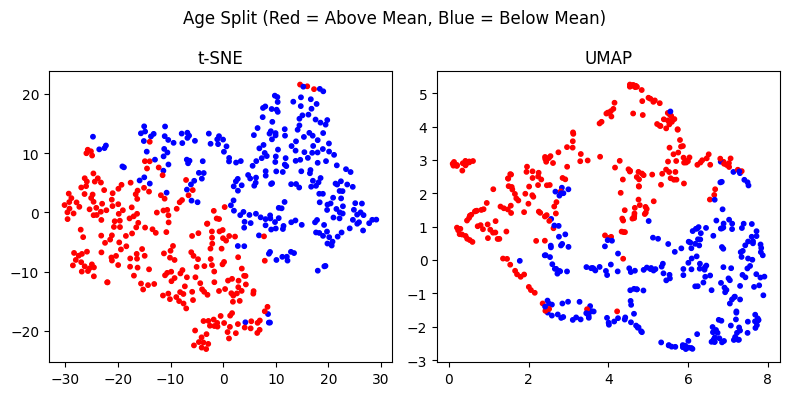

In [24]:
age_split = (all_age > all_age.mean()).astype(float)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].scatter(latent_2d_tsne[:, 0], latent_2d_tsne[:, 1], c=age_split, cmap='bwr', s=10)
axes[0].set_title("t-SNE")
axes[1].scatter(latent_2d_umap[:, 0], latent_2d_umap[:, 1], c=age_split, cmap='bwr', s=10)
axes[1].set_title("UMAP")
plt.suptitle("Age Split (Red = Above Mean, Blue = Below Mean)")
plt.tight_layout()
plt.show()

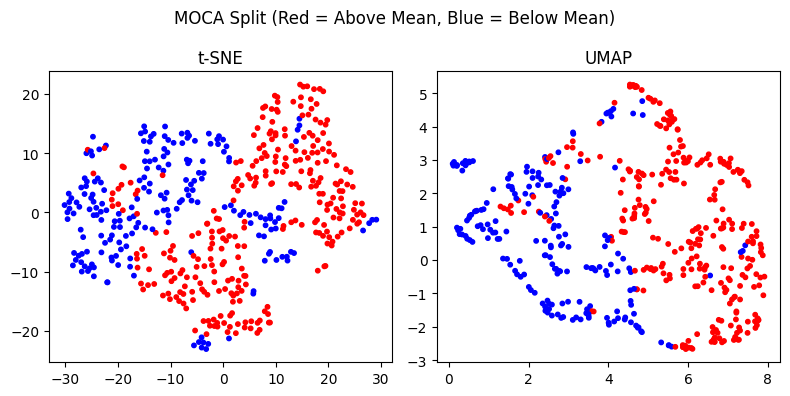

In [25]:
moca_split = (all_moca > all_moca.mean()).astype(float)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].scatter(latent_2d_tsne[:, 0], latent_2d_tsne[:, 1], c=moca_split, cmap='bwr', s=10)
axes[0].set_title("t-SNE")
axes[1].scatter(latent_2d_umap[:, 0], latent_2d_umap[:, 1], c=moca_split, cmap='bwr', s=10)
axes[1].set_title("UMAP")
plt.suptitle("MOCA Split (Red = Above Mean, Blue = Below Mean)")
plt.tight_layout()
plt.show()

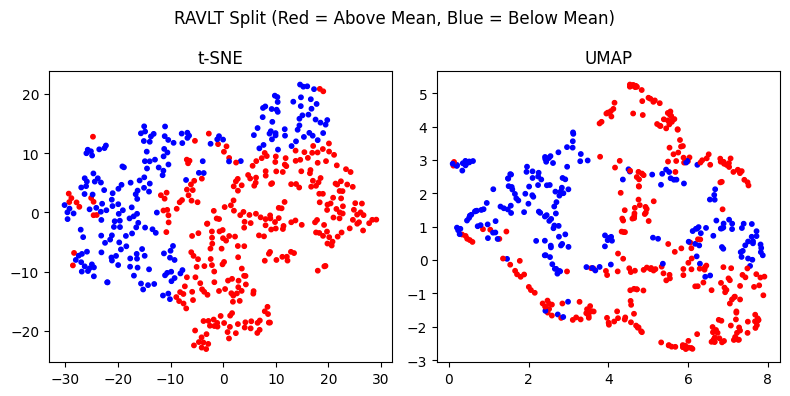

In [26]:
ravlt_split = (all_ravlt > all_ravlt.mean()).astype(float)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].scatter(latent_2d_tsne[:, 0], latent_2d_tsne[:, 1], c=ravlt_split, cmap='bwr', s=10)
axes[0].set_title("t-SNE")
axes[1].scatter(latent_2d_umap[:, 0], latent_2d_umap[:, 1], c=ravlt_split, cmap='bwr', s=10)
axes[1].set_title("UMAP")
plt.suptitle("RAVLT Split (Red = Above Mean, Blue = Below Mean)")
plt.tight_layout()
plt.show()

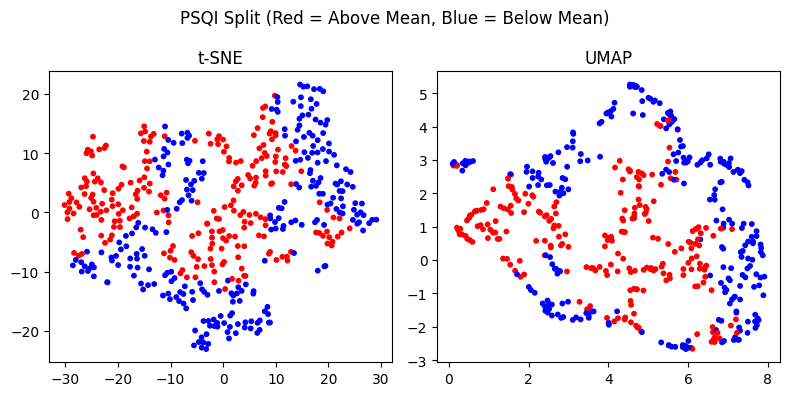

In [27]:
psqi_split = (all_psqi > all_psqi.mean()).astype(float)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].scatter(latent_2d_tsne[:, 0], latent_2d_tsne[:, 1], c=psqi_split, cmap='bwr', s=10)
axes[0].set_title("t-SNE")
axes[1].scatter(latent_2d_umap[:, 0], latent_2d_umap[:, 1], c=psqi_split, cmap='bwr', s=10)
axes[1].set_title("UMAP")
plt.suptitle("PSQI Split (Red = Above Mean, Blue = Below Mean)")
plt.tight_layout()
plt.show()

In [28]:
import random

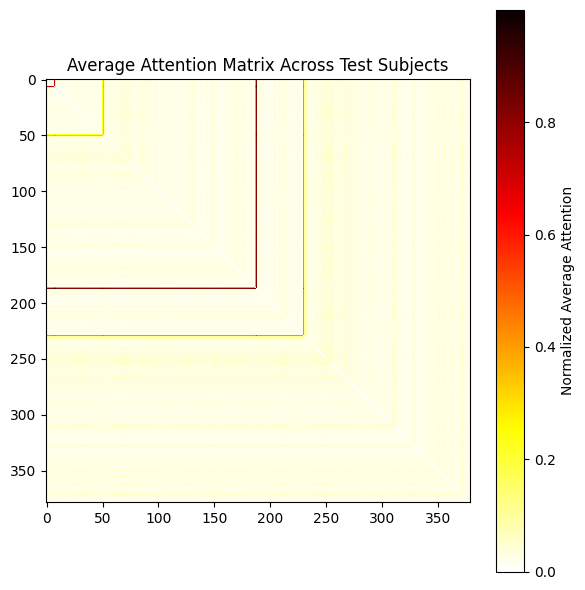

In [29]:
# Spectral Analysis - Alex
all_attn_matrices = {}

attn_samples = random.sample(train_data, 100)
with torch.no_grad():
  for batch in train_loader:
    batch = batch.to(device='cuda' if torch.cuda.is_available() else 'cpu')
    _, (edge_index, attn_weights) = model.gat1(
        batch.x.float(), batch.edge_index, return_attention_weights=True
    )
    attn_mean = attn_weights.mean(dim=1).cpu().numpy()
    batch_graph_ptr = batch.ptr.cpu().numpy()
    edge_index_np = edge_index.cpu().numpy()

    for i, subj_id in enumerate(batch.subject_id):
      start = batch_graph_ptr[i]
      end = batch_graph_ptr[i+1]
      node_mask = (edge_index_np[0] >= start) & (edge_index_np[0] < end)
      idxs = np.where(node_mask)[0]
      attn_mat = np.zeros((379, 379))

      for j in idxs:
        u = edge_index_np[0, j] - start
        v = edge_index_np[1, j] - start
        attn_mat[u, v] = attn_mean[j]
        attn_mat[v, u] = attn_mean[j]

        all_attn_matrices[subj_id] = attn_mat

# Average Attention Matrix
attn_stack = np.stack(list(all_attn_matrices.values()), axis=0)

avg_attn = np.mean(attn_stack, axis=0)

plt.figure(figsize=(6, 6))
plt.imshow(avg_attn / (avg_attn.max() + 1e-8), cmap='hot_r', interpolation='nearest')
plt.colorbar(label="Normalized Average Attention")
plt.title("Average Attention Matrix Across Test Subjects")
plt.tight_layout()
plt.show()

In [30]:
print(len(all_attn_matrices))

496


In [31]:
for batch in train_data:
  print(batch.age)
  break

tensor(-0.6885)


In [32]:
def analyze_consensus_all_subjects(train_data, all_attn_matrices,
                                   percentile=80, p=6, k_clusters=6):
    """
    Perform consensus analysis for all subjects

    Args:
        percentile: Keep top X% of edges by attention (e.g., 80 = top 20%)
        p: Number of eigenvectors for spectral clustering
        k_clusters: Number of clusters
    """
    results = {}
    for data in train_data:
      attn = all_attn_matrices[data.subject_id]
      L = laplacian_from_adj(data.x)

      spec_labels, vals, vecs = spectral_subnetworks_from_L(L, p=p, k_clusters=k_clusters)
      high_attn_edges = extract_high_attention_edges(attn, percentile=percentile)
      spectral_edges = extract_spectral_edges(spec_labels)
      consensus_subnetworks = find_consensus_subnetworks(
          high_attn_edges, spectral_edges, spec_labels
      )
      metrics = compute_consensus_metrics(consensus_subnetworks, high_attn_edges)
      results[data.subject_id] = {
          'consensus_subnetworks': consensus_subnetworks,
          'metrics': metrics,
          'spec_labels': spec_labels,
          'high_attn_edges': high_attn_edges
      }

    return results

In [33]:
import numpy as np
from scipy.spatial.distance import cosine
from sklearn.cluster import KMeans
from scipy.linalg import eigh
import networkx as nx

# Laplacian
def laplacian_from_adj(A):
    A = np.array(A, dtype=float)
    np.fill_diagonal(A, 0)
    A = np.clip(A, a_min=0, a_max=None)
    D = np.diag(A.sum(axis=1))
    return D - A

# Spectral subnetworks
def spectral_subnetworks_from_L(L, p=6, k_clusters=6, normalize_eigvecs=True):
    vals, vecs = eigh(L)
    Vp = vecs[:, :p]
    if normalize_eigvecs:
        Vp = Vp / (np.linalg.norm(Vp, axis=1, keepdims=True) + 1e-12)
    kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(Vp)
    labels = kmeans.labels_
    return labels, vals[:p], Vp

# Extract high-attention edges
def extract_high_attention_edges(attn_mat, percentile=80):
    """
    Extract top X percentile of edges by attention weight.
    Returns edge list as set of (i,j) tuples where i < j

    Args:
        attn_mat: NxN attention matrix
        percentile: Keep edges above this percentile (0-100)
                   e.g., 80 = top 20% of edges
    """
    N = attn_mat.shape[0]
    mat = attn_mat.copy()
    np.fill_diagonal(mat, 0)

    # Get all non-zero attention values
    all_weights = []
    for i in range(N):
        for j in range(i+1, N):
            weight = max(mat[i, j], mat[j, i])  # Take max of both directions
            if weight > 0:
                all_weights.append(weight)

    if len(all_weights) == 0:
        return set()

    # Compute threshold based on percentile
    threshold = np.percentile(all_weights, percentile)

    # Extract edges above threshold
    high_attn_edges = set()
    for i in range(N):
        for j in range(i+1, N):
            weight = max(mat[i, j], mat[j, i])
            if weight >= threshold:
                high_attn_edges.add((i, j))

    return high_attn_edges

# Extract spectral cluster edges
def extract_spectral_edges(spec_labels):
    """
    Extract edges within each spectral cluster.
    Returns dict mapping cluster_id -> set of edges
    """
    N = len(spec_labels)
    spectral_edges = {}

    for cluster_id in np.unique(spec_labels):
        cluster_nodes = np.where(spec_labels == cluster_id)[0]
        edges_in_cluster = set()

        # All edges within this cluster
        for i in cluster_nodes:
            for j in cluster_nodes:
                if i < j:  # Avoid duplicates
                    edges_in_cluster.add((i, j))

        spectral_edges[cluster_id] = edges_in_cluster

    return spectral_edges

# Find consensus subnetworks
def find_consensus_subnetworks(high_attn_edges, spectral_edges, spec_labels):
    """
    Find edges that appear in BOTH high-attention and spectral clusters.

    Returns:
        consensus_subnetworks: dict with cluster_id -> consensus info
    """
    consensus_subnetworks = {}

    for cluster_id, cluster_edges in spectral_edges.items():
        # Find intersection: edges in both sets
        consensus_edges = high_attn_edges.intersection(cluster_edges)

        # Calculate overlap metrics
        n_consensus = len(consensus_edges)
        n_cluster = len(cluster_edges)

        if n_cluster > 0:
            overlap_ratio = n_consensus / n_cluster
        else:
            overlap_ratio = 0

        # Get nodes in this cluster
        cluster_nodes = np.where(spec_labels == cluster_id)[0]

        # Get nodes involved in consensus edges
        consensus_nodes = set()
        for i, j in consensus_edges:
            consensus_nodes.add(i)
            consensus_nodes.add(j)

        consensus_subnetworks[cluster_id] = {
            'consensus_edges': consensus_edges,
            'n_consensus_edges': n_consensus,
            'n_cluster_edges': n_cluster,
            'overlap_ratio': overlap_ratio,
            'cluster_nodes': cluster_nodes.tolist(),
            'consensus_nodes': list(consensus_nodes),
            'n_consensus_nodes': len(consensus_nodes)
        }

    return consensus_subnetworks

# Metrics for consensus analysis
def compute_consensus_metrics(consensus_subnetworks, high_attn_edges):
    """
    Compute aggregate metrics across all consensus subnetworks
    """
    # Total consensus edges across all clusters
    total_consensus_edges = set()
    for data in consensus_subnetworks.values():
        total_consensus_edges.update(data['consensus_edges'])

    # What fraction of high-attention edges are in consensus?
    consensus_coverage = len(total_consensus_edges) / len(high_attn_edges) if len(high_attn_edges) > 0 else 0

    # How many clusters have meaningful consensus?
    significant_clusters = sum(1 for data in consensus_subnetworks.values()
                              if data['overlap_ratio'] > 0.1)  # >10% overlap

    return {
        'total_consensus_edges': len(total_consensus_edges),
        'total_high_attn_edges': len(high_attn_edges),
        'consensus_coverage': consensus_coverage,
        'n_significant_clusters': significant_clusters,
        'n_total_clusters': len(consensus_subnetworks)
    }

# Full analysis for all subjects
# def analyze_consensus_all_subjects(train_data, all_attn_matrices,
#                                    percentile=80, p=6, k_clusters=6):
#     """
#     Perform consensus analysis for all subjects

#     Args:
#         percentile: Keep top X% of edges by attention (e.g., 80 = top 20%)
#         p: Number of eigenvectors for spectral clustering
#         k_clusters: Number of clusters
#     """
#     for subj_id, cov in cov_dict.items():
#         if subj_id not in all_attn_matrices:
#             continue

#         attn = all_attn_matrices[subj_id]
#         L = laplacian_from_adj(cov)

#         # Spectral clustering
#         spec_labels, vals, vecs = spectral_subnetworks_from_L(L, p=p, k_clusters=k_clusters)

#         # Extract high-attention edges (PERCENTILE-BASED)
#         high_attn_edges = extract_high_attention_edges(attn, percentile=percentile)

#         # Extract spectral cluster edges
#         spectral_edges = extract_spectral_edges(spec_labels)

#         # Find consensus
#         consensus_subnetworks = find_consensus_subnetworks(
#             high_attn_edges, spectral_edges, spec_labels
#         )

#         # Compute metrics
#         metrics = compute_consensus_metrics(consensus_subnetworks, high_attn_edges)

#         results[subj_id] = {
#             'consensus_subnetworks': consensus_subnetworks,
#             'metrics': metrics,
#             'spec_labels': spec_labels,
#             'high_attn_edges': high_attn_edges
#         }

#     return results

# CROSS-SUBJECT CONSENSUS ANALYSIS
def aggregate_consensus_across_subjects(consensus_results, min_subjects=0.5):
    """
    Find consensus edges that appear consistently across multiple subjects.
    """
    n_subjects = len(consensus_results)

    if min_subjects <= 1.0:
        min_count = int(min_subjects * n_subjects)
    else:
        min_count = int(min_subjects)

    # Count how many subjects have each consensus edge
    edge_counts = {}

    for subj_id, result in consensus_results.items():
        # Get all consensus edges for this subject
        all_consensus_edges = set()
        for cluster_data in result['consensus_subnetworks'].values():
            all_consensus_edges.update(cluster_data['consensus_edges'])

        # Count each edge
        for edge in all_consensus_edges:
            if edge not in edge_counts:
                edge_counts[edge] = []
            edge_counts[edge].append(subj_id)

    # Filter edges that appear in enough subjects
    reproducible_edges = {}
    for edge, subjects in edge_counts.items():
        count = len(subjects)
        if count >= min_count:
            reproducible_edges[edge] = {
                'count': count,
                'frequency': count / n_subjects,
                'subjects': subjects
            }

    return reproducible_edges, edge_counts

def find_reproducible_subnetworks(reproducible_edges, min_edge_frequency=0.3, min_cluster_size=5):
    """
    Identify cohesive subnetworks formed by reproducible consensus edges.
    """
    # Build graph from reproducible edges
    G = nx.Graph()
    for edge, data in reproducible_edges.items():
        if data['frequency'] >= min_edge_frequency:
            G.add_edge(edge[0], edge[1], weight=data['frequency'])

    # Find connected components (cohesive subnetworks)
    subnetworks = []
    for component in nx.connected_components(G):
        if len(component) >= min_cluster_size:
            nodes = list(component)
            edges = [(u, v) for u, v in G.edges() if u in component and v in component]

            # Calculate average edge frequency
            avg_frequency = np.mean([reproducible_edges[(min(u,v), max(u,v))]['frequency']
                                    for u, v in edges])

            subnetworks.append({
                'nodes': sorted(nodes),
                'n_nodes': len(nodes),
                'edges': edges,
                'n_edges': len(edges),
                'avg_edge_frequency': avg_frequency,
                'density': len(edges) / (len(nodes) * (len(nodes) - 1) / 2) if len(nodes) > 1 else 0
            })

    # Sort by number of nodes (largest first)
    subnetworks.sort(key=lambda x: x['n_nodes'], reverse=True)

    return subnetworks

def summarize_cluster_consistency(consensus_results):
    """
    Analyze which spectral clusters consistently have high consensus across subjects.
    """
    # Track cluster metrics across all subjects
    cluster_stats = {}

    for subj_id, result in consensus_results.items():
        for cluster_id, data in result['consensus_subnetworks'].items():
            if cluster_id not in cluster_stats:
                cluster_stats[cluster_id] = {
                    'overlap_ratios': [],
                    'n_consensus_edges': [],
                    'n_nodes': [],
                    'subjects_with_cluster': []
                }

            cluster_stats[cluster_id]['overlap_ratios'].append(data['overlap_ratio'])
            cluster_stats[cluster_id]['n_consensus_edges'].append(data['n_consensus_edges'])
            cluster_stats[cluster_id]['n_nodes'].append(len(data['cluster_nodes']))
            cluster_stats[cluster_id]['subjects_with_cluster'].append(subj_id)

    # Compute summary statistics
    summary = []
    for cluster_id, stats in cluster_stats.items():
        summary.append({
            'cluster_id': cluster_id,
            'n_subjects': len(stats['subjects_with_cluster']),
            'mean_overlap': np.mean(stats['overlap_ratios']),
            'std_overlap': np.std(stats['overlap_ratios']),
            'mean_consensus_edges': np.mean(stats['n_consensus_edges']),
            'mean_nodes': np.mean(stats['n_nodes']),
            'high_overlap_subjects': sum(1 for x in stats['overlap_ratios'] if x > 0.1)
        })

    # Sort by mean overlap (best performing clusters first)
    summary.sort(key=lambda x: x['mean_overlap'], reverse=True)

    return summary


# BRAIN REGION MAPPING FUNCTIONS
def map_subnetworks_to_regions(subnetworks, roi_labels):
    """
    Map node IDs in subnetworks to actual brain region names.

    Args:
        subnetworks: List of subnetwork dictionaries
        roi_labels: List of ROI names (e.g., ['R_V1_ROI', 'R_MST_ROI', ...])

    Returns:
        Subnetworks with added 'region_names' field
    """
    for subnet in subnetworks:
        region_names = [roi_labels[node_id] for node_id in subnet['nodes']]
        subnet['region_names'] = region_names

    return subnetworks

def print_subnetwork_regions(subnetworks, roi_labels, n_subnetworks=3):
    """
    Pretty print brain regions in each subnetwork.
    """
    print("BRAIN REGIONS IN REPRODUCIBLE SUBNETWORKS")

    for idx, subnet in enumerate(subnetworks[:n_subnetworks], 1):
        print(f"\n--- Subnetwork {idx} ({subnet['n_nodes']} regions) ---")

        region_names = [roi_labels[node_id] for node_id in subnet['nodes']]

        # Group by hemisphere if ROI names start with L_ or R_
        left_regions = [r for r in region_names if r.startswith('L_')]
        right_regions = [r for r in region_names if r.startswith('R_')]
        other_regions = [r for r in region_names if not (r.startswith('L_') or r.startswith('R_'))]

        if right_regions:
            print(f"\nRight hemisphere ({len(right_regions)} regions):")
            for r in sorted(right_regions):
                print(f"  {r}")

        if left_regions:
            print(f"\nLeft hemisphere ({len(left_regions)} regions):")
            for r in sorted(left_regions):
                print(f"  {r}")

        if other_regions:
            print(f"\nOther regions ({len(other_regions)}):")
            for r in sorted(other_regions):
                print(f"  {r}")

def analyze_subnetwork_composition(subnetworks, roi_labels):
    """
    Analyze what types of brain regions appear in subnetworks.
    """
    print("SUBNETWORK COMPOSITION ANALYSIS")

    for idx, subnet in enumerate(subnetworks[:3], 1):
        region_names = [roi_labels[node_id] for node_id in subnet['nodes']]

        # Count region types (based on common prefixes in HCP parcellation)
        region_types = {}
        for region in region_names:
            # Extract region type (e.g., V1, MST, FEF from R_V1_ROI)
            parts = region.split('_')
            if len(parts) >= 2:
                region_type = parts[1]  # e.g., 'V1', 'MST', '4'
                region_types[region_type] = region_types.get(region_type, 0) + 1

        print(f"\nSubnetwork {idx}:")
        print(f"  Total regions: {len(region_names)}")
        print(f"  Unique region types: {len(region_types)}")
        print(f"  Most common types:")

        # Sort by frequency
        sorted_types = sorted(region_types.items(), key=lambda x: x[1], reverse=True)
        for region_type, count in sorted_types[:10]:
            print(f"    {region_type}: {count}")

# MAIN ANALYSIS PIPELINE

# k=10
fixed_k = 10  # Choose number of clusters
print(f"\nUsing k={fixed_k} clusters\n")

k_values = [fixed_k]
multi_scale_results = {}

for k in k_values:
    results = analyze_consensus_all_subjects(
        train_data,
        all_attn_matrices,
        percentile=80,
        p=min(15, k),
        k_clusters=k
    )

    coverage_scores = [r['metrics']['consensus_coverage'] for r in results.values()]
    sig_clusters = [r['metrics']['n_significant_clusters'] for r in results.values()]
    consensus_edges = [r['metrics']['total_consensus_edges'] for r in results.values()]

    multi_scale_results[k] = {
        'results': results,
        'mean_coverage': np.mean(coverage_scores),
        'std_coverage': np.std(coverage_scores),
        'mean_sig_clusters': np.mean(sig_clusters),
        'mean_consensus_edges': np.mean(consensus_edges)
    }

    print(f"  Coverage: {np.mean(coverage_scores):.3f} ± {np.std(coverage_scores):.3f}")
    print(f"  Significant clusters: {np.mean(sig_clusters):.1f}")
    print(f"  Consensus edges: {np.mean(consensus_edges):.1f}")

best_k = fixed_k
consensus_results = multi_scale_results[best_k]['results']

best_k = fixed_k
consensus_results = multi_scale_results[best_k]['results']

# Cross-subject reproducibility
print("CROSS-SUBJECT REPRODUCIBILITY")

reproducible_edges, all_edge_counts = aggregate_consensus_across_subjects(
    consensus_results,
    min_subjects=0.3
)

print(f"\nTotal unique consensus edges: {len(all_edge_counts)}")
print(f"Reproducible edges (≥30% subjects): {len(reproducible_edges)}")

# Show most reproducible edges
print("TOP 50 MOST REPRODUCIBLE CONSENSUS EDGES")
print(f"\n{'Rank':<6} {'Edge (i,j)':<20} {'Frequency':<12} {'# Subjects':<12}")

sorted_edges = sorted(reproducible_edges.items(),
                     key=lambda x: x[1]['frequency'],
                     reverse=True)

for rank, (edge, data) in enumerate(sorted_edges[:50], 1):
    print(f"{rank:<6} {str(edge):<20} {data['frequency']:<12.3f} {data['count']:<12}")

#  Find subnetworks
print("REPRODUCIBLE SUBNETWORKS")

subnetworks = find_reproducible_subnetworks(
    reproducible_edges,
    min_edge_frequency=0.3,
    min_cluster_size=5
)

print(f"\nFound {len(subnetworks)} reproducible subnetworks\n")

for idx, subnet in enumerate(subnetworks[:5]):
    print(f"Subnetwork {idx+1}:")
    print(f"  Nodes: {subnet['n_nodes']} nodes")
    print(f"  Edges: {subnet['n_edges']} edges")
    print(f"  Avg edge frequency: {subnet['avg_edge_frequency']:.3f}")
    print(f"  Density: {subnet['density']:.3f}")
    print(f"  Node IDs: {subnet['nodes'][:15]}{'...' if len(subnet['nodes']) > 15 else ''}")
    print()

# Show edges in each subnetwork
print("EDGES IN EACH REPRODUCIBLE SUBNETWORK")

for idx, subnet in enumerate(subnetworks[:3], 1):
    print(f"\nSubnetwork {idx} ({subnet['n_nodes']} nodes, {subnet['n_edges']} edges)")

    # Get edges with frequencies
    subnet_edges_with_freq = []
    for edge in subnet['edges']:
        edge_tuple = (min(edge[0], edge[1]), max(edge[0], edge[1]))
        if edge_tuple in reproducible_edges:
            freq = reproducible_edges[edge_tuple]['frequency']
            subnet_edges_with_freq.append((edge_tuple, freq))

    # Sort by frequency
    subnet_edges_with_freq.sort(key=lambda x: x[1], reverse=True)

    # Show top 20 or all
    n_show = min(20, len(subnet_edges_with_freq))
    print(f"\nTop {n_show} edges by frequency:")
    print(f"{'Edge':<20} {'Frequency':<12}")

    for edge, freq in subnet_edges_with_freq[:n_show]:
        print(f"{str(edge):<20} {freq:<12.3f}")

    if len(subnet_edges_with_freq) > n_show:
        print(f" and {len(subnet_edges_with_freq) - n_show} more edges")

# Cluster consistency
print("SPECTRAL CLUSTER CONSISTENCY")

cluster_summary = summarize_cluster_consistency(consensus_results)

print(f"\n{'Cluster':<10} {'N Subj':<10} {'Mean Overlap':<15} {'High Overlap':<15} {'Mean Edges':<12}")

for stats in cluster_summary[:15]:
    print(f"{stats['cluster_id']:<10} {stats['n_subjects']:<10} "
          f"{stats['mean_overlap']:<15.3f} {stats['high_overlap_subjects']:<15} "
          f"{stats['mean_consensus_edges']:<12.1f}")



Using k=10 clusters

  Coverage: 0.186 ± 0.072
  Significant clusters: 4.5
  Consensus edges: 2664.5
CROSS-SUBJECT REPRODUCIBILITY

Total unique consensus edges: 57411
Reproducible edges (≥30% subjects): 2337
TOP 50 MOST REPRODUCIBLE CONSENSUS EDGES

Rank   Edge (i,j)           Frequency    # Subjects  
1      (np.int64(7), np.int64(187)) 0.927        460         
2      (50, 230)            0.887        440         
3      (np.int64(188), np.int64(230)) 0.867        430         
4      (np.int64(52), np.int64(187)) 0.865        429         
5      (51, 187)            0.863        428         
6      (np.int64(52), np.int64(188)) 0.861        427         
7      (50, 188)            0.857        425         
8      (39, 187)            0.853        423         
9      (np.int64(187), np.int64(188)) 0.847        420         
10     (np.int64(7), np.int64(230)) 0.845        419         
11     (np.int64(38), np.int64(187)) 0.845        419         
12     (7, 50)              0.845    

In [34]:
# Map to brain regions

# Extract ROI labels from one of your covariance CSV files
def load_roi_labels(csv_path):
    df = pd.read_csv(csv_path, header=None)

    # Get labels from first row, skip the first cell (which is usually empty or "ROI")
    roi_labels = df.iloc[0, 1:].tolist()

    # Clean up labels (remove any extra whitespace, NaN, etc.)
    roi_labels = [str(label).strip() for label in roi_labels if pd.notna(label)]

    return roi_labels

# Load ROI labels from the first subject's file
roi_labels = load_roi_labels(os.path.join(corr_dir, f"{test_subject}.csv"))

print(f"Extracted {len(roi_labels)} ROI labels")
print(f"First 10 labels: {roi_labels[:10]}")
print(f"Last 10 labels: {roi_labels[-10:]}")

# Print regions in each subnetwork
print_subnetwork_regions(subnetworks, roi_labels, n_subnetworks=3)

# Analyze composition
analyze_subnetwork_composition(subnetworks, roi_labels)

Extracted 379 ROI labels
First 10 labels: ['R_V1_ROI', 'R_MST_ROI', 'R_V6_ROI', 'R_V2_ROI', 'R_V3_ROI', 'R_V4_ROI', 'R_V8_ROI', 'R_4_ROI', 'R_3b_ROI', 'R_FEF_ROI']
Last 10 labels: ['DIENCEPHALON_VENTRAL_LEFT', 'CEREBELLUM_RIGHT', 'THALAMUS_RIGHT', 'CAUDATE_RIGHT', 'PUTAMEN_RIGHT', 'PALLIDUM_RIGHT', 'HIPPOCAMPUS_RIGHT', 'AMYGDALA_RIGHT', 'ACCUMBENS_RIGHT', 'DIENCEPHALON_VENTRAL_RIGHT']
BRAIN REGIONS IN REPRODUCIBLE SUBNETWORKS

--- Subnetwork 1 (154 regions) ---

Right hemisphere (113 regions):
  R_13l_ROI
  R_1_ROI
  R_23c_ROI
  R_24dd_ROI
  R_24dv_ROI
  R_2_ROI
  R_33pr_ROI
  R_3a_ROI
  R_3b_ROI
  R_43_ROI
  R_46_ROI
  R_4_ROI
  R_52_ROI
  R_55b_ROI
  R_5L_ROI
  R_5m_ROI
  R_5mv_ROI
  R_6a_ROI
  R_6d_ROI
  R_6ma_ROI
  R_6mp_ROI
  R_6r_ROI
  R_6v_ROI
  R_7AL_ROI
  R_7Am_ROI
  R_7PC_ROI
  R_7PL_ROI
  R_A1_ROI
  R_A4_ROI
  R_A5_ROI
  R_AIP_ROI
  R_DVT_ROI
  R_FEF_ROI
  R_FFC_ROI
  R_FOP1_ROI
  R_FOP2_ROI
  R_FOP3_ROI
  R_FOP4_ROI
  R_FOP5_ROI
  R_FST_ROI
  R_IFJa_ROI
  R_IFJp_ROI
  R_IFS

In [ ]:
import pandas as pd
import re
from collections import Counter

# Load and normalize brain region CSV
def load_brain_regions(csv_path):
    df = pd.read_csv(csv_path)
    region_map = {}

    for _, row in df.iterrows():
        key = row['regionName']

        # Replace '-' with '_'
        key = key.replace('-', '_')

        # Move hemisphere to front if at the end
        if key.endswith('_L'):
            key = 'L_' + key[:-2]
        elif key.endswith('_R'):
            key = 'R_' + key[:-2]

        region_map[key] = {
            'regionLongName': row['regionLongName'],
            'cortex': row['cortex']
        }

    return region_map

# Map subnetwork nodes to region names + cortex
def map_subnetworks_with_labels(subnetworks, roi_labels, region_map):
    mapped_subnetworks = []

    for subnet in subnetworks:
        region_names = []
        cortex_names = []
        for idx in subnet['nodes']:
            label = roi_labels[idx]

            # Remove _ROI from ROI label
            label_fixed = label.removesuffix('_ROI')

            label_fixed = re.sub(r'(?<=\d)-(?=\d)', '_', label_fixed)

            # Search in normalized CSV region map
            matched = None
            cortex = "Unknown"
            for key in region_map:
                if label_fixed in key:
                    matched = region_map[key]['regionLongName']
                    cortex = region_map[key]['cortex']
                    break
            if matched is None:
                matched = f"Unknown_{label_fixed}"

            region_names.append(matched)
            cortex_names.append(cortex)

        new_subnet = subnet.copy()
        new_subnet['region_names'] = region_names
        new_subnet['cortex_names'] = cortex_names
        mapped_subnetworks.append(new_subnet)

    return mapped_subnetworks

csv_path = "/content/drive/Shareddrives/291A_Brain_Connectomes/HCP-MMP1_UniqueRegionList.csv"
region_map = load_brain_regions(csv_path)

mapped_subnetworks = map_subnetworks_with_labels(subnetworks, roi_labels, region_map)

# Print subnetworks
for idx, subnet in enumerate(mapped_subnetworks):
    print(f"\nSubnetwork {idx+1} ({subnet['n_nodes']} nodes):")
    print(f"{'Region':<35} {'Cortex'}")
    print("-" * 50)
    for region, cortex in zip(subnet['region_names'], subnet['cortex_names']):
        print(f"{region:<35} {cortex}")

    # Compute and print cortex frequency
    cortex_counter = Counter(subnet['cortex_names'])
    print("\nCortex frequencies:")
    for cortex, count in sorted(cortex_counter.items(), key=lambda x: x[1], reverse=True):
        pct = 100 * count / len(subnet['cortex_names'])
        print(f"{cortex:<45} {count} ({pct:.1f}%)")



Subnetwork 1 (154 nodes):
Region                              Cortex
--------------------------------------------------
Primary_Visual_Cortex_R             Primary_Visual
Medial_Superior_Temporal_Area_R     MT+_Complex_and_Neighboring_Visual_Areas
Sixth_Visual_Area_R                 Dorsal_Stream_Visual
Second_Visual_Area_R                Early_Visual
Third_Visual_Area_R                 Early_Visual
Fourth_Visual_Area_R                Early_Visual
Eighth_Visual_Area_R                Ventral_Stream_Visual
Primary_Motor_Cortex_R              Somatosensory_and_Motor
Primary_Sensory_Cortex_R            Somatosensory_and_Motor
Frontal_Eye_Fields_R                Premotor
Premotor_Eye_Field_R                Premotor
Area_55b_R                          Premotor
Area_V3A_R                          Dorsal_Stream_Visual
Seventh_Visual_Area_R               Dorsal_Stream_Visual
IntraParietal_Sulcus_Area_1_R       Dorsal_Stream_Visual
Fusiform_Face_Complex_R             Ventral_Stream_Visual
Area_